In [1]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as fc
import torch
import torch.nn as nn
import numpy as np
# plt.ion()

In [2]:
def generate_toy_dataset(eps, n=20):
    x = np.random.uniform(-6,6, size=n)
    return np.sort(x), func(np.sort(x), eps)

In [3]:
def func(x, eps):
    return np.power(x,3) + eps

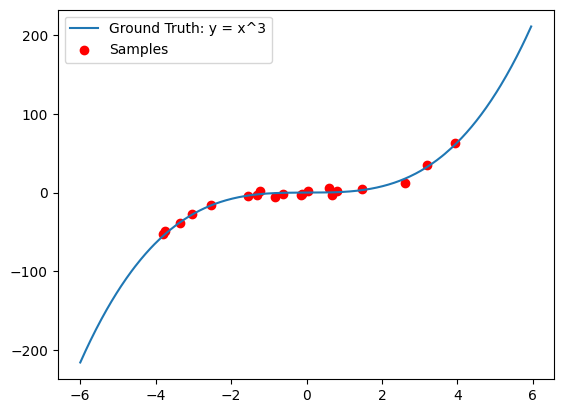

In [4]:
eps = np.random.normal(loc=0.0, scale=0.0, size=1000)
population_dataset_x, population_dataset_y = generate_toy_dataset(eps, n=1000)
sample_points_x = np.random.uniform(-4,4, size=20)
eps = np.random.normal(loc=0.0, scale=3.0, size=20)
sample_points_y = func(sample_points_x, eps)
plt.plot(population_dataset_x, population_dataset_y, label='Ground Truth: y = x^3')
plt.scatter(sample_points_x,sample_points_y, color='r', label='Samples')
plt.legend()
plt.show()

## Building Deterministic MLP with MSE Loss

In [5]:
class DeterministicMLP(nn.Module):
    def __init__(self, layer_sizes=[100], inp_shape=1, out_shape=1):
        super(DeterministicMLP, self).__init__()
        self.network = nn.Sequential()
        self.network.append(nn.Linear(inp_shape, layer_sizes[0]))
        self.network.append(nn.ReLU())
        for i in range(1,len(layer_sizes)-1):
            self.network.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            self.network.append(nn.ReLU())
        self.network.append(nn.Linear(layer_sizes[-1], out_shape))
    
    def forward(self, x):
        return self.network(x)

### Model Training

In [6]:
model = DeterministicMLP(layer_sizes=[100])
opt = torch.optim.Adam(model.parameters(),lr=0.1)
loss_criterion = nn.MSELoss(reduction='sum')

In [7]:
for _ in range(400):
    shuffle_index = np.random.choice(np.arange(sample_points_x.shape[0]),sample_points_x.shape, replace=False)
    x = torch.tensor(sample_points_x[shuffle_index]).reshape(-1,1).float()
    y = torch.tensor(sample_points_y[shuffle_index]).reshape(-1,1).float()
    y_hat = model(x)
    opt.zero_grad()
    loss = loss_criterion(y_hat, y)
    loss.backward()
    opt.step()

In [8]:
model.eval()
with torch.no_grad():
    y_hat = model(torch.tensor(population_dataset_x).reshape(-1,1).float())

In [9]:
f = plt.Figure(figsize=(13,6))
fc(f)

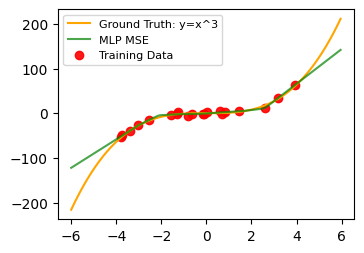

In [10]:
ax = f.add_subplot(231)
ax.plot(population_dataset_x, population_dataset_y, color='orange', label='Ground Truth: y=x^3')
ax.plot(population_dataset_x, y_hat, color='g', alpha=0.7, label='MLP MSE')
ax.scatter(sample_points_x,sample_points_y, color='r', alpha=0.9, label='Training Data')
ax.legend(prop={'size': 8})
f

## Building Gaussian Model Class

In [11]:
import torch.nn.functional as F

In [12]:
class ProbabilisticMLP(nn.Module):
    def __init__(self, layer_sizes=[100], inp_shape=1, out_shape=1):
        super(ProbabilisticMLP, self).__init__()
        self.network = nn.Sequential()
        self.network.append(nn.Linear(inp_shape, layer_sizes[0]))
        self.network.append(nn.ReLU())
        for i in range(1,len(layer_sizes)-1):
            self.network.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            self.network.append(nn.ReLU())
        self.fc_mu = nn.Linear(layer_sizes[-1], out_shape)
        self.fc_var = nn.Linear(layer_sizes[-1], out_shape)
    
    def forward(self, x):
        x = self.network(x)
        mu = self.fc_mu(x)
        var = self.fc_var(x)
        var_pos = F.softplus(var) + 1e-06
        return mu, var_pos

### Building Trainer functions

In [13]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [14]:
def ensemble_training_loop(train_x, train_y, model_class=None, m=5, fgsm=False, epochs=400, loss_func='mle', **kwargs):
    # m -> number of ensembles
    models = []

    for _ in range(m):
        np.random.seed(_)
        torch.manual_seed(_)
        model = model_class(layer_sizes=kwargs['layer_size'])
        opt = torch.optim.Adam(model.parameters(),lr=kwargs['lr'])
        model.train()
        for _ in range(epochs):
            shuffle_index = np.random.choice(np.arange(train_x.shape[0]),train_x.shape, replace=False)
            for x,y in zip(train_x[shuffle_index], train_y[shuffle_index]):
                opt.zero_grad()
                x = torch.tensor([x]).float()
                x.requires_grad=True
                y = torch.tensor([y]).float()
                mu, var = model(x)
                if loss_func == 'mse':
                    y_hat = torch.distributions.Normal(mu,var**0.5).rsample()
                    loss = loss_criterion(y_hat, y)
                elif loss_func == 'nnl':
                    loss = torch.sum(torch.log(var)/2.0 + (0.5*(y-mu)**2/var))
                else:
                    assert False, f"Loss {loss_func} is not supported"
                loss.backward()
                if fgsm:
                    sign = x.grad.data.sign()
                    opt.zero_grad()
                    x = torch.tensor([x,x+(0.01*sign*8)]).float().reshape(-1,1)
                    y = torch.tensor([y,y]).float().reshape(-1,1)
                    mu, var = model(x)
                    if loss_func == 'mse':
                        y_hat = torch.distributions.Normal(mu,var**0.5).rsample()
                        loss = loss_criterion(y_hat, y)
                    elif loss_func == 'nnl':
                        loss = torch.sum(torch.log(var)/2.0 + (0.5*(y-mu)**2/var))
                    else:
                        assert False, f"Loss {loss_func} is not supported"
                    loss.backward()
                opt.step()

        models.append(model)
    return models

In [15]:
def get_ensemble_output(test_x, models):
    mu_meter = AverageMeter()
    var_meter = AverageMeter()

    for model in models:
        model.eval()
        with torch.no_grad():
            mu, var = model(torch.tensor(test_x).reshape(-1,1).float())
            mu_meter.update(mu.reshape(-1))

    for model in models:
        model.eval()
        with torch.no_grad():
            mu, var = model(torch.tensor(test_x).reshape(-1,1).float())
            var_meter.update(mu.reshape(-1)**2 + var.reshape(-1))

    mu = mu_meter.avg
    var = var_meter.avg - mu**2
    
    return mu, var

In [16]:
def plot_ensemble_output(gt_x, gt_y, train_x, train_y, mu, var, label='', ax=None):
    ax.plot(gt_x, gt_y, color='orange', label='Ground Truth: y=x^3')
    ax.plot(gt_x, mu, color='g', label=label)
    ax.fill_between(gt_x, mu-(3.0* var**0.5), mu+(3.0* var**0.5), color='g', alpha=0.5)
    ax.scatter(train_x,train_y, color='r', alpha=0.9, label='Training Data')
    ax.legend(prop={'size': 8})

### Building Probabilistic MLP with MSE Loss with M=5

In [17]:
models = ensemble_training_loop(sample_points_x,
                                sample_points_y,
                                model_class=ProbabilisticMLP,
                                m=5,
                                fgsm=False,
                                loss_func='mse',
                                lr=0.1,
                                layer_size=[100])

In [18]:
mu, var = get_ensemble_output(population_dataset_x, models)

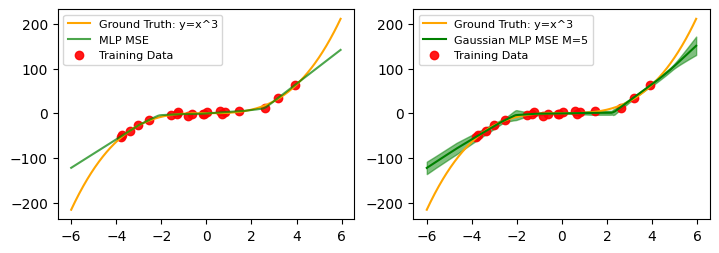

In [19]:
ax = f.add_subplot(232)
plot_ensemble_output(population_dataset_x, 
                    population_dataset_y, 
                    sample_points_x, 
                    sample_points_y, 
                    mu, var, 
                    label='Gaussian MLP MSE M=5',
                    ax=ax)
f

## Building Probabilistic MLP with NNL Loss

### Number of Ensembles = 1

In [20]:
models = ensemble_training_loop(sample_points_x,
                                sample_points_y,
                                model_class=ProbabilisticMLP,
                                m=1,
                                fgsm=False,
                                loss_func='nnl',
                                lr=0.1,
                                layer_size=[100])

In [21]:
mu, var = get_ensemble_output(population_dataset_x, models)

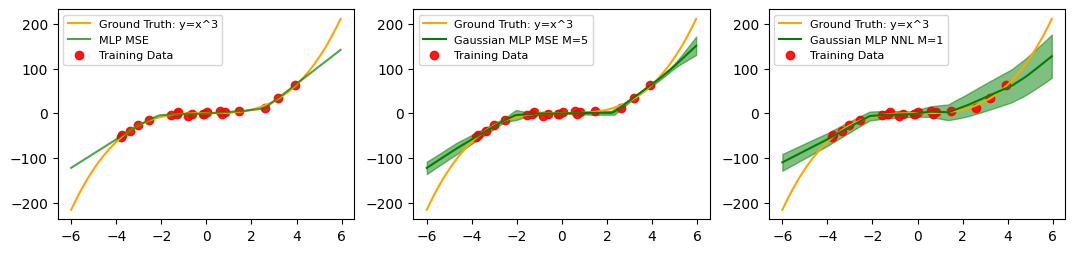

In [22]:
ax = f.add_subplot(233)
plot_ensemble_output(population_dataset_x, 
                    population_dataset_y, 
                    sample_points_x, 
                    sample_points_y, 
                    mu, var, 
                    label='Gaussian MLP NNL M=1',
                    ax=ax)

f

### Number of Models=5

In [23]:
models = ensemble_training_loop(sample_points_x,
                                sample_points_y,
                                model_class=ProbabilisticMLP,
                                m=5,
                                fgsm=False,
                                loss_func='nnl',
                                lr=0.1,
                                layer_size=[100])

In [24]:
mu, var = get_ensemble_output(population_dataset_x, models)

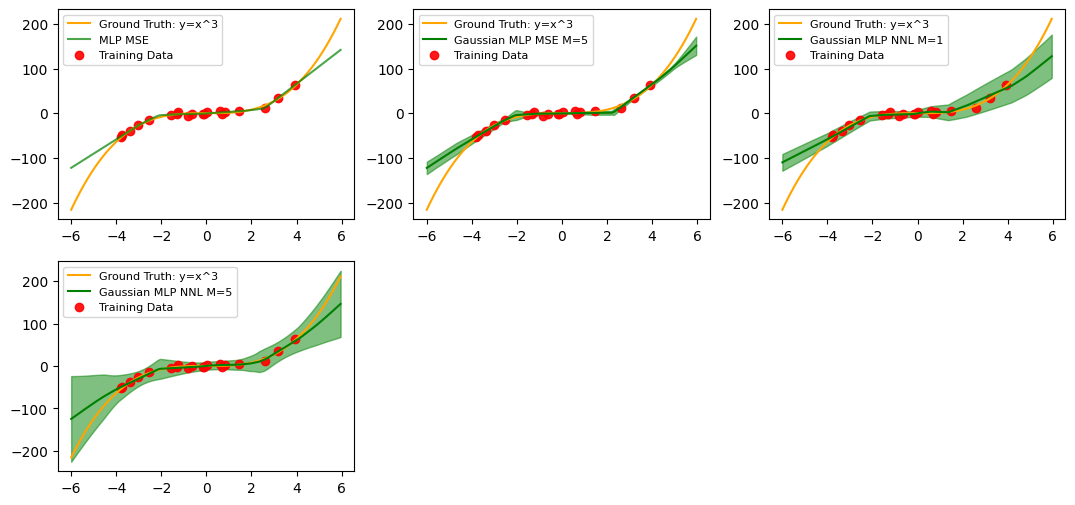

In [25]:
ax = f.add_subplot(234)
plot_ensemble_output(population_dataset_x, 
                    population_dataset_y, 
                    sample_points_x, 
                    sample_points_y, 
                    mu, var, 
                    label='Gaussian MLP NNL M=5',
                   ax=ax)

f

### Number of Ensembles=1 with Fast Gradient Sign Adversarial examples

In [26]:
models = ensemble_training_loop(sample_points_x,
                                sample_points_y,
                                model_class=ProbabilisticMLP,
                                m=1,
                                fgsm=True,
                                loss_func='nnl',
                                lr=0.1,
                                layer_size=[100])

In [27]:
mu, var = get_ensemble_output(population_dataset_x, models)

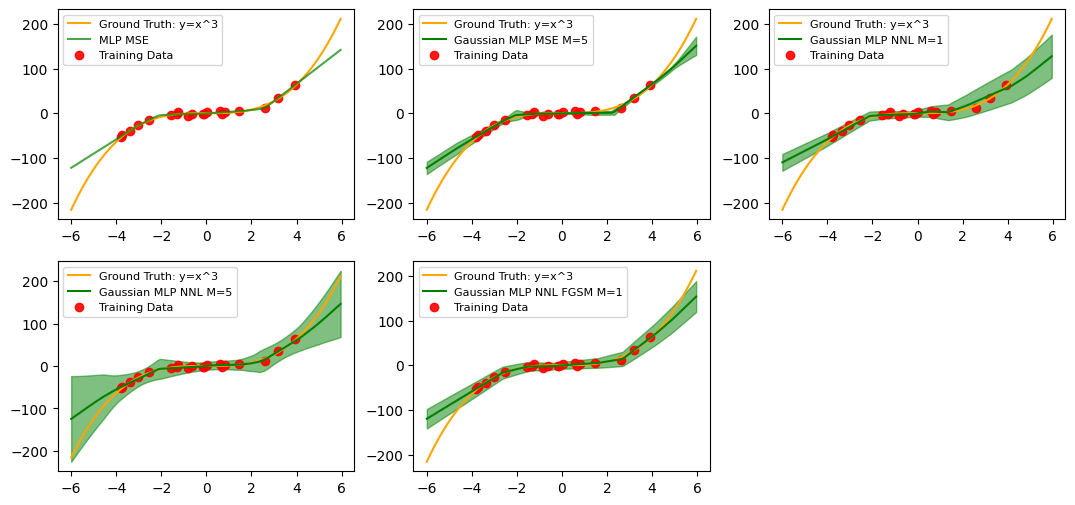

In [28]:
ax = f.add_subplot(235)

plot_ensemble_output(population_dataset_x, 
                    population_dataset_y, 
                    sample_points_x, 
                    sample_points_y, 
                    mu, var, 
                    label='Gaussian MLP NNL FGSM M=1',
                   ax=ax)

f

### Number of Models=5 with Fast Gradient Sign Adversarial examples

In [29]:
models = ensemble_training_loop(sample_points_x,
                                sample_points_y,
                                model_class=ProbabilisticMLP,
                                m=5,
                                fgsm=True,
                                loss_func='nnl',
                                lr=0.1,
                                layer_size=[100])

In [30]:
mu, var = get_ensemble_output(population_dataset_x, models)

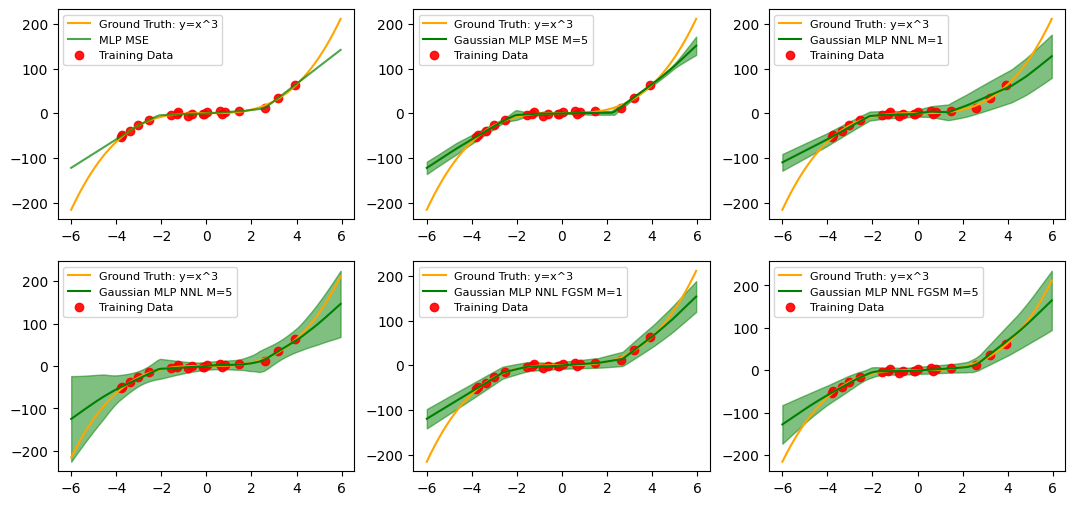

In [31]:
ax = f.add_subplot(236)

plot_ensemble_output(population_dataset_x, 
                    population_dataset_y, 
                    sample_points_x, 
                    sample_points_y, 
                    mu, var, 
                    label='Gaussian MLP NNL FGSM M=5',
                   ax=ax)
f